# 이용자들의 다음달 이용횟수 예측하기

In [1]:
import pandas as pd
customer = pd.read_csv('customer_join.csv') # 어제 전처리를 완료한 파일

In [2]:
customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [3]:
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [6]:
# K-means를 활용하여 cluster를 4개 만들고, 만들어진 결과를 cluster라는 이름의 칼럼으로 추가 (10:30)
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# 스케일 변환
scaler = MinMaxScaler()
customer_clustering_std = scaler.fit_transform(customer_clustering)

# 군집
kmeans = KMeans(n_clusters = 4)
kmeans.fit(customer_clustering_std)

# 생성 된 클러스터를 데이터 프레임에 넣습니다.
clusters = kmeans.labels_
customer_clustering.copy().loc[:, 'cluster'] = clusters

In [9]:
# agg(<새롭게 들어갈 칼럼의 이름> = (<계산하는데 활용할 칼럼>,<연산 방법>))
customer_clustering.groupby('cluster', as_index = False).agg(count = ('mean','count'))

,cluster,count
0,0,1255
1,1,856
2,2,1093
3,3,988


In [11]:
customer_clustering.groupby('cluster', as_index = False).mean()

,cluster,mean,median,max,min,membership_period
0,0,3.711459,3.468924,6.244622,1.720319,8.079681
1,1,8.000136,7.960280,9.974299,6.099299,6.300234
2,2,4.627325,4.618024,7.183898,2.106130,38.343092
3,3,5.863162,5.865891,8.675101,3.104251,21.779352


In [14]:
# pca를 활용해서 2차원으로 데이터를 축소하고 seaborn을 활용해서 시각화 (11시 25분)
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #2차원으로 변환하라는 코딩
pca.fit(customer_clustering_std)

PCA(n_components=2)

In [25]:
pca_df = pd.DataFrame(pca.transform(customer_clustering_std), columns = ['X','Y'])
pca_df.loc[:,'cluster'] = clusters
pca_df.head(1)

,X,Y,cluster
0,-0.479714,-0.313094,2


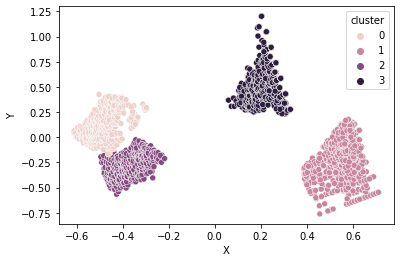

In [26]:
import seaborn as sns
sns.scatterplot(data = pca_df, x = 'X', y = 'Y', hue = 'cluster')

In [31]:
customer_clustering = pd.concat([customer, customer_clustering['cluster']], axis = 1)

In [35]:
customer_clustering.groupby(['cluster','is_deleted' ], as_index = False).agg(count = ('customer_id', 'count'))

,cluster,is_deleted,count
0,0,0,4
1,0,1,1251
2,1,0,799
3,1,1,57
4,2,0,1093
5,3,0,946
6,3,1,42


In [38]:
customer_clustering.groupby(['cluster','routine_flg' ], as_index = False).agg(count = ('customer_id', 'count'))

,cluster,routine_flg,count
0,0,0,695
1,0,1,560
2,1,0,80
3,1,1,776
4,2,1,1093
5,3,0,4
6,3,1,984


# 이 유저가 다음달에는 몇번이나 올까?

In [44]:
uselog = pd.read_csv('use_log.csv')
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['customer_id','연월'], as_index = False).agg(count = ('log_id', 'count'))
uselog_months.head(3)

,customer_id,연월,count
0,AS002855,201804,4
1,AS002855,201805,5
2,AS002855,201806,5


In [65]:
uselog_pivot = pd.pivot_table(data = uselog_months, index = 'customer_id', columns = '연월', values = 'count', fill_value = 0)

total_column_count = len(uselog_pivot.columns)
set_column_count = 6 # 6 개월의 데이터를 가지고 다음달을 예측
result_df = pd.DataFrame()
for i in range(total_column_count-set_column_count):
  selected_df = uselog_pivot.iloc[:, i:i+7] # 칼럼[0:7] ~ 칼럼[5:12] 
  print(selected_df.columns) 
  selected_df.columns = ['count1', 'count2', 'count3','count4', 'count5', 'count6', 'pred' ]
  result_df = pd.concat([result_df, selected_df])
result_df

Index(['201804', '201805', '201806', '201807', '201808', '201809', '201810'], dtype='object', name='연월')
Index(['201805', '201806', '201807', '201808', '201809', '201810', '201811'], dtype='object', name='연월')
Index(['201806', '201807', '201808', '201809', '201810', '201811', '201812'], dtype='object', name='연월')
Index(['201807', '201808', '201809', '201810', '201811', '201812', '201901'], dtype='object', name='연월')
Index(['201808', '201809', '201810', '201811', '201812', '201901', '201902'], dtype='object', name='연월')
Index(['201809', '201810', '201811', '201812', '201901', '201902', '201903'], dtype='object', name='연월')


,count1,count2,count3,count4,count5,count6,pred
customer_id,,,,,,,
AS002855,4,5,5,5,3,7,3
AS008805,0,0,8,7,5,2,2
AS009013,2,0,0,0,0,0,0
AS009373,3,4,4,7,6,6,5
AS015233,0,7,7,5,11,9,7
...,...,...,...,...,...,...,...
TS995853,0,0,0,0,0,11,8
TS998593,9,9,9,7,8,7,8
TS999079,4,6,6,9,6,2,3


In [74]:
predict_data = pd.merge(result_df.reset_index(), customer[['customer_id','membership_period']], on = 'customer_id')
predict_data.head()

,customer_id,count1,count2,count3,count4,count5,count6,pred,membership_period
0,AS002855,4,5,5,5,3,7,3,29
1,AS002855,5,5,5,3,7,3,5,29
2,AS002855,5,5,3,7,3,5,2,29
3,AS002855,5,3,7,3,5,2,6,29
4,AS002855,3,7,3,5,2,6,5,29


In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

X = predict_data.drop(['pred','customer_id'], axis = 1)
Y = predict_data['pred']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3)

model = LinearRegression()
model.fit(X_train,Y_train)

model.score(X_test, Y_test)

0.5064653422821684

In [105]:
coef = pd.DataFrame({"feature_names" : model.feature_names_in_, "coefficient": model.coef_})
coef

,feature_names,coefficient
0,count1,-0.041235
1,count2,-0.009911
2,count3,0.022397
3,count4,0.065756
4,count5,0.196422
5,count6,0.523108
6,membership_period,0.008325


In [97]:
print(model.feature_names_in_)

['count1' 'count2' 'count3' 'count4' 'count5' 'count6' 'membership_period']


In [104]:
model.predict([[1, 2, 3, 4, 5, 6, 20],
               [1, 2, 3, 4, 5, 6, 20]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([5.3213781, 5.3213781])